# Regression

### Problem - Predict a Crocodile's age

You are employed by the UACA (United Association of Crocodiles and Aligators) and they have a new task for you. Some of your colleagues,
(data collection officers) travel around the world and track crocodiles in the wild. They have just gotten back from a recent trip and
have a problem. They would like to predict the age of new crocodiles they begin tracking.

### Features

The data contains 1 feature and one label:

- weights (in pounds), will be denoted as $x^{(i)}$
- age (in years), will be denoted $y^{(i)}$

For simplicity, let us assume that ages, and weight behave like real numbers.

### Data Visualizaton

Before we start our problem it is helpful to a look at the data we have:

<AxesSubplot:xlabel='weight', ylabel='age'>

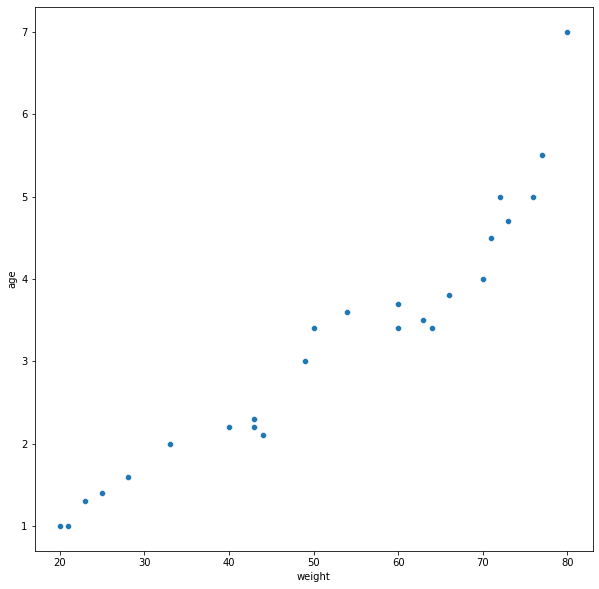

In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

from regression import models, evaluate, train

logging.basicConfig(level=logging.ERROR, format='%(message)s')

# Import pseudo data set
df = pd.read_csv('../data/tabular/croc-age.csv')
df_np = df.to_numpy()
training_data = df_np[:,0]
training_data_2_feat = df_np[:,0:2].T # For two features
labels = df_np[:,2] # age

#Visualize the data
plt.subplots(figsize=(10,10))
sns.scatterplot(data=df, x="weight", y='age')

## Choosing a model

What exactly is our goal? Well, we want to come up with some continuous function $f$ such that we can use $f$ to predict the age of a crocodile.
To start, it seems like our goal should be to decide what type of continuous function $f$ should be. That is, should $f$ be linear, quadratic, etc...

Well by visually inspecting the data we already have, we can see that there might exist some linear relationship between weight and age. Therefore, let us
assume that $f$ is a linear model where $f: \mathbb{R} \rightarrow  \mathbb{R}$ and let the output of $f$ be $\hat y$ where
$\hat y = \theta x^{(i)} + \theta_0$

### Evaluating our model

So now that we have chosen a way to represent our problem, what now need is some way of quantifying the correctness of our model.
That is, how correct or incorrect is our model. This is the role of a loss function. A loss function maps some value (in our case a real number)
to real number where the output represents the 'cost' of that value. $L :\mathbb{R} \rightarrow \mathbb{R}$.

Given that we already have some observed data, one logical idea is to compare our model $\hat y$ with an observed value $y^{(i)}$ and see what our error is.
 We can even square the result so that larger errors are penalized. This is appropriately called the squared error loss. It is expressed as:

$L(\hat y) = (y^{(i)} - \hat y)^2$

We are generally interested in the total avg loss, so now our expression becomes:

$
\text{training_loss}  = \frac{1}{n} \sum\limits_{i=0}^{n}
    ( y^{(i)} - \hat y)^2
$

## Optimizing our model


### Visualizing loss

Now that we have our model and have a way to evaluate it, the only thing left to do is find or rather estimate the 'best' $\theta, \theta_0$
such that the training_loss returns the lowest possible result. To start we will just focus on trying to estimate $\theta$.

Anytime we are trying to optimize our model, it is helpful to express this intent by referring to our loss function and model as an objective function.
Therefore, let  $J$ be our objective function such that $J: \mathbb{R} \rightarrow  \mathbb{R}$. Note that our objective function still tells us the loss as a function of our model.

$J(\theta;\text{Data}) = \frac{1}{n} \sum\limits_{i=0}^{n} ( y^{(i)} - (\theta * x^{(i)}))^2 $

And now let us visualize our loss curve by running some values through $J$



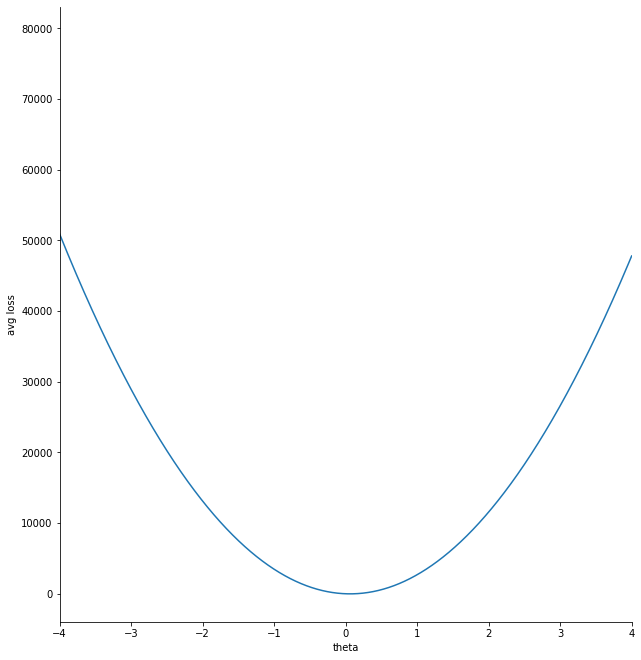

In [2]:
potential_theta_values = np.arange(-5,5,.001)

def loss(t: float) -> float:
    model = models.LinearRegression(theta=np.array([t]))
    return evaluate.training_loss(model, training_data, labels)

loss_f = np.vectorize(loss)

plot = sns.relplot(x=potential_theta_values,y=loss_f(potential_theta_values), kind="line", facet_kws=dict(sharex=False))
plot.set(xlabel ="theta", ylabel = "avg loss")
plot.axes[0,0].set_xlim(-4,4)
plot.fig.set_size_inches(10,10)


### Properties of $J$

There are two important properties of $J$ that are briefly worth mentioning.

- Differentiability.

$J$ is differentiable everywhere, we will soon see why this is important.

- Convex.

$J$ is convex. A function is convex:

"If the line segment between any two points on the graph of the function lies above the graph between the two points." There is an
accompanying algebraic definition but this will do for now. Another looser geometric interpretation is that a function takes on a 'bowl shape', as we can see above.

Why do we care? Well, if we are trying to find the `lowest possible loss` we ideally want to find a value of theta at the global minimum.
If $J$ is convex, we know it has a global minimum, and we ideally want to find a way to determine this value. If our
function is not convex, searching for the global minimum can be more difficult.

### Estimating theta

By visual inspection we can see that our best theta is somewhere around 0. Instead of choosing a zero based $\theta$,
 let $\theta=.06$ . Let's overlay a line on our scatter plot to see what this looks like.





Model: y = 0 + 0.06x     Training loss: [0.311856]


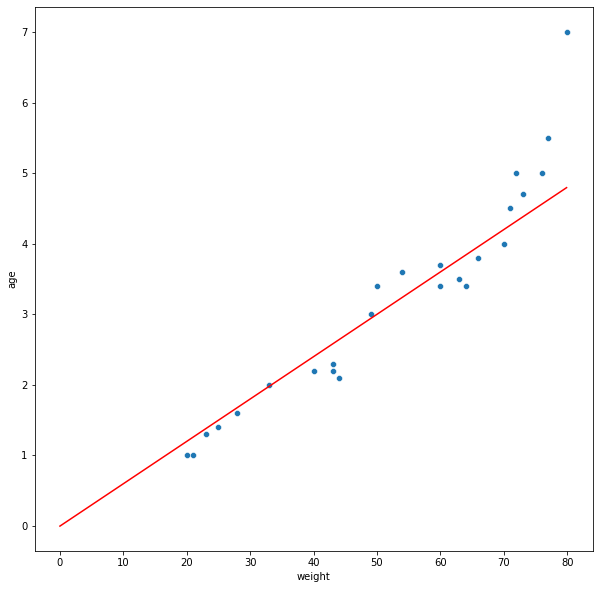

In [3]:
# Plot data
plt.subplots(figsize=(10,10))
plot = sns.scatterplot(data=df, x="weight", y='age')

# Overlay linear model
model = models.LinearRegression(theta=np.array([.06]))
training_loss = evaluate.training_loss(model, training_data, labels)
print(f'Model: {model}  Training loss: {training_loss}')

def eq_of_line(x) -> float:
    return model.predict(x)

line = np.vectorize(eq_of_line)
domain = np.arange(0,80,.1)
plot.plot(domain, line(domain), color='r')




#### Residuals

A small comment!

The really nice thing about single variable regression problems, is that we can actually geometrically interpret what 'loss' looks like in the image above.
The distance between our line and a data point (a small line connecting the two points) is called a residual. A residual is the distance: $(\hat y - \theta * x^{(i)})$

And the average of the squared residuals is our total loss! There are a lot of resources that do a great animating residuals and how they change w.r.t a model.

## Gradient descent

We can see that the average loss for our model is `.31185`. It would be great if we could get some algorithm to estimate $\hat y$ for us, find the minimum and achieve a lower loss.
Lucky for us there are many techniques to do this, but we will use a popular iterative version of an algorithm called gradient descent to solve this problem.
The key insight to gradient descent, is that we will use the derivative to help us reach our global minimum.

At a high level the algorithm looks like:
   - choose a random value of $\theta$
   - uses the derivative to update $\theta$ in an intelligent way
   - stop when we reach our minimum

### The usefulness of derivatives

If we determine the derivative at a point
   - larger derivatives -> nudging theta yields high loss
   - smaller derivatives -> nudging theta yields low loss
   - the sign of the derivative also points in the direction of ascent / descent

Thus, the derivative gives us 2 key pieces of information, how much to move and what direction to move.

#### How much to move

If the derivative is larger, this means we are very far from our minimum. So we should take a 'big step' aka update
our $\theta$ by a large value. And if the derivative is smaller, this means we are very close to the minimum, so we should take
a 'small step'. So we can use the derivative as a way to determine how large our step size should be!

#### Direction

We always want to move in the direction of the minimum. It can be helpful to reference
our graph where training_loss was a function of theta. To build up intuition, let's imagine that we are increasing $\theta$
from negative values to positive values. Two things can happen:
   1. $J(\theta)$ increases. This means the derivative is positive and we are moving away from the minimum. Thus, we
         should nudge theta in the opposite direction. Derivative is +, change direction and move theta -.
   2. $J(\theta)$ decreases. This means the derivative is negative, and we are moving towards the minimum. Thus, we should
        nudge theta in the same direction. Derivative is -, continue in + direction

In both cases notice negating the sign of derivative, allows us to 'point' $\theta$ in the correct direction!

#### Update rules

If we combine the observations above our update rule for theta is:

$\theta \leftarrow \theta + (\text{learning rate} * (-1 * \text{derivative}) $

What is this learning_rate?  Well we established that the size our update should be proportional to derivative, so this additional parameter is just our
proportionality constant that tells us exactly how big our step size should be. It is important to note that this value is chosen by us, the user of this algorithm.


#### Computing the derivative

Recall our objective function:

$
J(\theta; x^{(i)}, y^{(i)}) =
\frac{1}{n} \sum\limits_{i=0}^{n}
    ( y^{(i)} - \theta * x^{(i)})^2
$

The derivative w.r.t $\theta$,

$$
\frac{d}{d\theta}
\frac{1}{n} \sum\limits_{i=0}^{n}
    ( y^{(i)} - \theta * x^{(i)})^2
=
\frac{1}{n} \sum\limits_{i=0}^{n}
\frac{d}{d\theta} ( y^{(i)} - \theta * x^{(i)})^2
=
\frac{1}{n} \sum\limits_{i=0}^{n}
-2( y^{(i)} - \theta * x^{(i)}) * x^{(i)}
$$




In [4]:

d_theta = lambda x, y, theta: -2 * (y - (theta*x)) * x

results = train.sp_descend(
        training_data
        , labels
        , learning_rate=.01
        , derivative_per_data_point=d_theta
        , maximum_num_epochs=100
)

gradient_model = results['model']
training_loss = evaluate.training_loss(gradient_model, training_data, labels)
print(f'Model: {gradient_model}  Training loss: {training_loss}')


Model: y = 0 -5.269839639115399e+174x    Training loss: [inf]


/Users/deo/Dev/data-sci/ml/regression/evaluate.py:34: RuntimeWarning: overflow encountered in add
  loss += difference
/Users/deo/Dev/data-sci/ml/regression/evaluate.py:12: RuntimeWarning: overflow encountered in square
  return x ** 2


## Problems with gradient descent

### Estimating Hyper-parameters

Whoa! That is not good, we can see that we have incurred infinite average loss and our theta is a massive number.

What happened? In our case our hyperparameter learning_rate was incorrectly configured. We ended up taking updating theta
in such a way where our 'step sizes' were too big and we 'stepped over' our minimum. Unfortunately there is no
analytical way to determine what this value must be, we must make intelligent estimates through trial an error.
Alternatively we could also loop over all possible learning_rates and choose the one that yields the lowest
loss.

In any case the lesson here is that gradient descent is extremely sensitive to this value.

### Learning schedule

One approach to solve this problem is to update the learning rate as the algorithm progresses. One can use the number of epochs
to determine this rate, or use additional parameters. There are many types of schedules and techniques, so we will not do a deep dive here.
We will instead focus on our simple use case.

Previously our learning rate was constant throughout the algorithm, and although the intention was that our update to theta should
get smaller and smaller as the derivative gets smaller, our steps were initially too large and did not decrease quickly enough.

To fix this, lets decrease our learning rate by a factor of $3/4$ each iteration and see if this makes a difference. Luckily `sv_descend()` has a `learning_schedule()`
parameter, so we will leverage this here. We will also decrease our initial learning rate as well.


Model: y = 0 + 0.05826x     Training loss: [0.35697575]


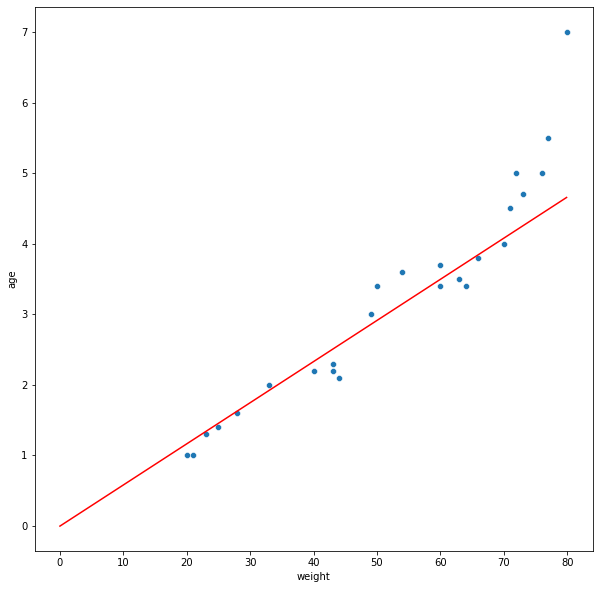

In [5]:
d_theta = lambda x, y, theta: -2 * (y - (theta*x)) * x
learning_schedule = lambda learning_rate, epoch: learning_rate * 3/4

results = train.sp_descend(
    training_data
    , labels
    , derivative_per_data_point=d_theta
    , learning_rate=.001
    , learning_schedule=learning_schedule
    , maximum_num_epochs=100
)

gradient_model = results['model']

training_loss = evaluate.training_loss(gradient_model, training_data, labels)
print(f'Model: {gradient_model}  Training loss: {training_loss}')

#Visualize the estimated model
plt.subplots(figsize=(10,10))
plot = sns.scatterplot(data=df, x="weight", y='age')

def eq_of_line(x) -> float:
    return gradient_model.predict(x)

line = np.vectorize(eq_of_line)
domain = np.arange(0,80,.1)
plot.plot(domain, line(domain), color='r')

#### Initialization is important

That is much better! Our loss is $ <.31185 $. However, notice that if we run this cell block a couple of more times we will get different values. This is because
everytime we run the algorithm, we randomly initialize theta everytime, and the better our initialization is or rather the closer it is to our minimum, the better our estimate will be.

#### Excessive derivative computations

Another issue with this naive version of gradient descent is the excessive amount of derivative computations.
In this piece of code:

```python
    for i in range(0, num_of_features):
        slope += derivative(feature_matrix[i], labels[i], theta)
```

We compute the derivative for each data point that we have. Additionally, we do this for each epoch!
So even with modest amount of data and epochs, such as $10,000$ data points and $1000$ epochs. That is $10,000,000$ derivative computations!
Now keep in mind that this just to estimate one parameter! We haven't discussed estimating our offset yet, but if we were to include
offset estimation, we will need to compute its derivative for each data point every epoch as well. This would be $20,000,000$ computations!!!
Clearly this does not scale well.

#### Stochastic gradient descent

Lucky for us there is a version of gradient descent called stochastic gradient descent which can helps us reduce these computations.
The algorithm is fairly similar, except for the following changes:

- On epoch 0, randomly shuffle the data, so we have $D$
- At each epoch, instead of calculating the $\dfrac{dJ}{d\theta}$ (where $J$'s parameter include all data points), we calculate $\dfrac{d \text{Loss}}{d\theta}$ of one data point $D_{i}$
So we would have: $2( y^{(i)} - \theta * x^{(i)}) * x^{(i)}$ vs $\frac{1}{n} \sum\limits_{i=0}^{n}-2( y^{(i)} - \theta * x^{(i)}) * x^{(i)}$
- On the next epoch, we calculate $\dfrac{d \text{Loss}}{d\theta}$ for $D_{i+1}$
- Continue until we've iterated through $D$


What is important to note here is we effectively have a new objective function $J$. One geometric way to think about our new
objective function and loss, is to return to the visualization of a line through our data. For each model theta / line in our
plane, we only care about one of the residuals, instead of the sum of the residuals. This means two things:

1. There will be many more cases where our gradient moves in the wrong direction. This happens because a candidate model thinks it has
a low loss, because it is biased towards one residual / data point, instead of being equally weighted across all data points / residuals.
2. We will need more epochs because of 1.

We can also visualize what our new loss function looks like:


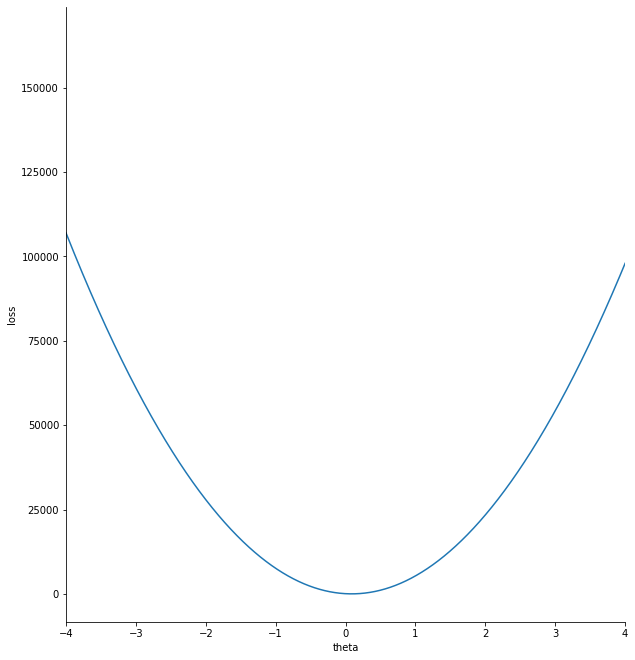

In [8]:
p = np.random.permutation(len(training_data))
shuffled_training_data, shuffled_labels = training_data[p], labels[p]

def loss(t: float, i: int) -> float:
    model = models.LinearRegression(theta=np.array([t]))
    loss = evaluate.training_loss(model, np.array([shuffled_training_data[i]]), np.array( [shuffled_labels[i]]))
    i+=1
    return loss

loss_f = np.vectorize(loss)

plot = sns.relplot(x=potential_theta_values,y=loss_f(potential_theta_values, 0), kind="line", facet_kws=dict(sharex=False))
plot.set(xlabel ="theta", ylabel = "loss")
plot.axes[0,0].set_xlim(-4,4)
plot.fig.set_size_inches(10,10)


If we run this code cell multiple times, we will see that we will initially start with a different loss each time.
This is because we randomly sort our training data.

##### Mini-batch stochastic gradient descent

There may be instances, where we actually want to comprise a bit, and instead of only computing the loss of one data point, we compute the loss
of 2, or $n$ where $n<\text{Data points}$. This is called mini-batch stochastic gradient descent.

This works especially well when we have redundancies in our data.

In any case, let us use mini-batch stochastic gradient descent and see how it compares:


Model: y = 0 -2.24734x    Training loss: [16466.20321727]


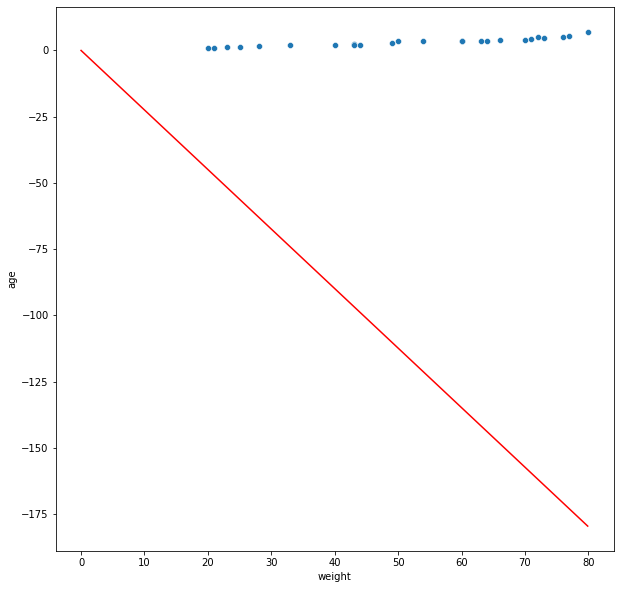

In [19]:
d_theta = lambda x, y, theta: -2 * (y - (theta*x)) * x
learning_schedule = lambda learning_rate, epoch: learning_rate * 3/4

results = train.sp_descend(
    training_data
    , labels
    , derivative_per_data_point=d_theta
    , learning_rate=.001
    , learning_schedule=learning_schedule
    , maximum_num_epochs=100
    , stochastic=True
    , mini_batch_number=4
)

gradient_model = results['model']

training_loss = evaluate.training_loss(gradient_model, training_data, labels)
print(f'Model: {gradient_model}  Training loss: {training_loss}')

#Visualize the estimated model
plt.subplots(figsize=(10,10))
plot = sns.scatterplot(data=df, x="weight", y='age')

def eq_of_line(x) -> float:
    return gradient_model.predict(x)

line = np.vectorize(eq_of_line)
domain = np.arange(0,80,.1)
plot.plot(domain, line(domain), color='r')


## Estimating both theta and the offset

Now if we would like to estimate $\theta_0$ as well, then our objective function becomes:


$
J(\theta, \theta_0; x^{(i)}, y^{(i)}) =
\frac{1}{n} \sum\limits_{i=0}^{n}
    ( y^{(i)} - (\theta * x^{(i)} + \theta_0)) )^2
$

So now we have a multivariable function! Again we can visualize what this looks like, except now we
must visualize in $\mathbb{R}^3$ .


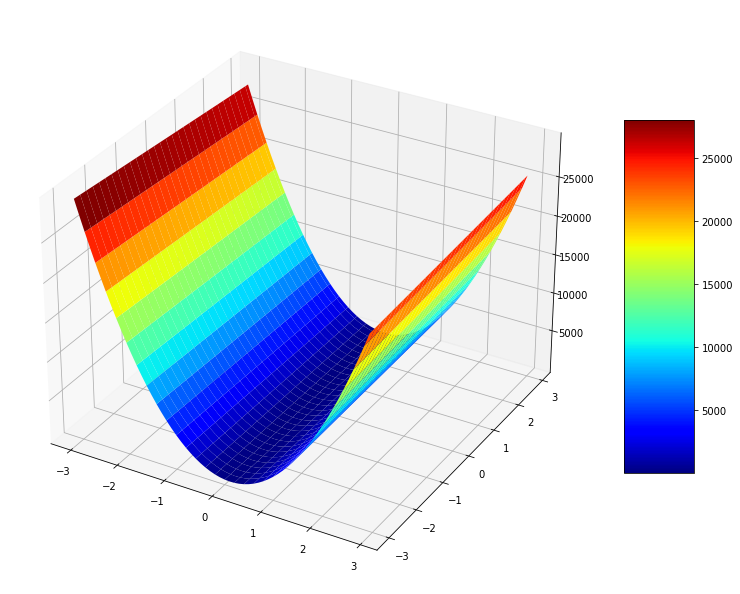

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

potential_theta_values =  np.arange(-3.0, 3.0, .1)
potential_theta_0_values = np.arange(-3.0, 3.0, .1)

def loss(t: float, t_0: float) -> float:
    model = models.LinearRegression(theta=np.array([t]), offset=t_0)
    return evaluate.training_loss(model, training_data, labels)
loss_f = np.vectorize(loss)

X, Y = np.meshgrid(potential_theta_values, potential_theta_0_values)
Z = np.array(loss_f(X,Y))

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y,Z, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()



Our function is convex again! We can use the same approach in the single variable case and 'descend' our loss function and search for the optimal value.
The only difference now is that instead of finding the derivative w.r.t. $\theta$, we also need the derivative w.r.t $\theta_0$. We are going to package these two values into the gradient, and use both partial derivatives to help us nudge our parameters towards our global maximum.

Let us compute the gradient:

We have
$
J(\theta, \theta_0; x^{(i)}, y^{(i)}) =
\frac{1}{n} \sum\limits_{i=0}^{n}
    ( y^{(i)} - (\theta * x^{(i)} + \theta_0))^2
$

And we want:

$
\begin{align*}
\nabla J = \langle \frac{\partial J}{\partial \theta} , \frac{\partial J}{\partial \theta_0}  \rangle \\
\end{align*}
$

Let us first compute the partial derivative for $\frac{\partial J}{\partial \theta}$

$$
\begin{align*}
 \frac{\partial }{\partial \theta} J &= \\
 \frac{\partial }{\partial \theta} (y^{(i)} - ((\theta \cdot x_1^{(i)} - \theta_0))^2 &= \\
 \frac{\partial J}{\partial u} * \frac{\partial u}{\partial v} * \frac{\partial v}{\partial \theta}  &= \text{ We-write using chain rule where }
  J = u^2 \text{ and } u = y^{(i)} - v \text{ and }  v = \theta \cdot x^{(i)} + \theta_0  \\
\end{align*}
$$

$$
\begin{align*}
 \frac{\partial J }{\partial u} = 2u &  \\
 \frac{\partial u }{\partial v} = -1  &  \\
 \frac{\partial v }{\partial \theta} = x^{(i)} & \\
\end{align*}
$$

And if we put it all together we get
$ 2 * (y^{(i)} - v) * -1 * x^{(i)}$
$ = 2(-y^{(i)} + v) * x^{(i)}$
$ = 2x^{(i)}(-y^{(i)} + ( \theta \cdot x^{(i)} + \theta_0) $


By a similar process we have $ \frac{\partial }{\partial \theta_0} J =   2(-y^{(i)} + (\theta \cdot x^{(i)} + \theta_0 )  $

So in summary, our gradient is

$
\begin{align*}
\nabla J = \langle \frac{\partial J}{\partial \theta}  \frac{\partial J}{\partial \theta_0}  \rangle  = \langle 2x^{(i)}(- y^{(i)} + (\theta \cdot x^{(i)} + \theta_0 )  , 2(-y^{(i)} + (\theta \cdot x^{(i)} + \theta_0 ) \rangle \ \\
\end{align*}
$

And if we package our parameters $\theta$ and $\theta_0$ into a vector $\overrightarrow{\theta} =  \langle \theta, \theta_0 \rangle$, then our update rule is almost identical!

Recall we had:

$\theta \leftarrow \theta + (\text{learning rate} * (-1 * \text{derivative}) $

And now, with our gradient we can just do an element wise update on our parameter vector:

$\overrightarrow{\theta}  \leftarrow \overrightarrow{\theta}  + (\text{learning rate} * (-1 * \nabla J ) $


Model: y = 1.99584 + 0.75224x     Training loss: [1611.75325822]


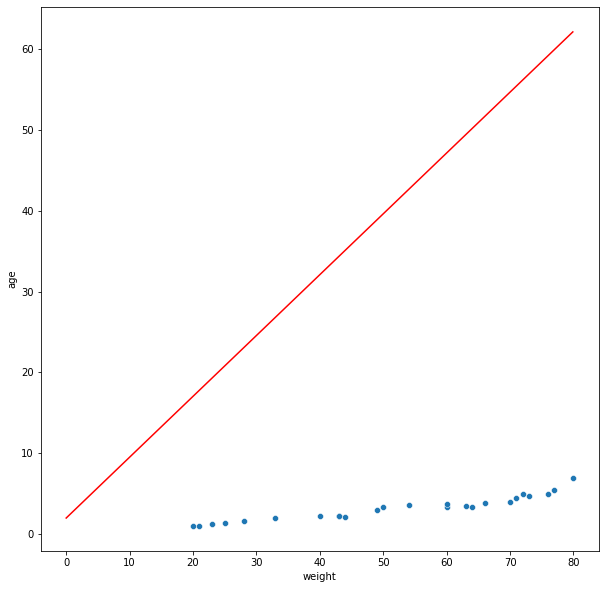

In [20]:
d_theta = lambda x, y, theta, theta_0: (2*x) * (-y + (theta*x + theta_0))
d_offset = lambda x, y, theta, theta_0: 2 * (-y + (theta*x + theta_0))
learning_schedule = lambda learning_rate, epoch: learning_rate * 3/4

results = train.tp_descend(
    training_data
    , labels
    , derivative_t_per_data_point= d_theta
    , derivative_o_per_data_point= d_offset
    , learning_rate=.0001
    , init_parameter_range= (-5, 5)
    , learning_schedule=learning_schedule
    , stochastic=True
    , mini_batch_number=4
    , maximum_num_epochs=100000
)

gradient_model = results['model']

training_loss = evaluate.training_loss(gradient_model, training_data, labels)
print(f'Model: {gradient_model}  Training loss: {training_loss}')

#Visualize the estimated model
plt.subplots(figsize=(10,10))
plot = sns.scatterplot(data=df, x="weight", y='age')

def eq_of_line(x) -> float:
    return gradient_model.predict(x)

line = np.vectorize(eq_of_line)
domain = np.arange(0,80,.1)
plot.plot(domain, line(domain), color='r')

## For two features

Let us suppose we want to use a new feature, length into our data set. Let us quickly visualize what this looks like:


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(training_data_2_feat[0], training_data_2_feat[1], labels)
ax.set_xlabel('weight (lbs)')
ax.set_ylabel('length (m)')
ax.set_zlabel('age (years)')
plt.show()




In [ ]:
learning_schedule = lambda learning_rate, epoch: learning_rate * 3/4
results = train.mp_descend(
    training_data_2_feat
    , labels
    , learning_rate=.0001
    , init_parameter_range= (-5, 5)
    , learning_schedule=learning_schedule
    , maximum_num_epochs=100000
)

gradient_model = results['model']

training_loss = evaluate.training_loss(gradient_model, training_data, labels)
print(f'Model: {gradient_model}  Training loss: {training_loss}')
